# Import library

In [1]:
import os
import sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

In [3]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [4]:
bucket_name = 'shine_v3_9_kt'
df_all = pd.read_csv(f"../pipeline/output/{bucket_name}/df_all_added_owid.csv")

In [5]:
size_and_ratio(df_all, 'pcr_result')

Sum : 15351 (2,)


,size,ratio
pcr_result,,
1,10232,0.666536
0,5119,0.333464


In [6]:
size_and_ratio(df_all, 'split')

Sum : 15351 (3,)


,size,ratio
split,,
TRAIN,9237,0.601720
TEST,3079,0.200573
VALIDATE,3035,0.197707


In [7]:
df_all[df_all['patient_id'] == 30888]

,patient_id,selfcheck_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask,positive_rate_norm,positive_rate_mask,reproduction_rate_norm,reproduction_rate_mask
450,30888,2022-03-04,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.394016,0.223707,0.084070,1,1.0,0.55,0,0,TRAIN,KOR,2022-03-04,0.111952,0.0,0.021444,0.0,0.102263,0.0,0.026331,0.0,0.006906,0.0,0.016711,0.0,0.085131,0.0,0.000000,1.0,0.0,1.0,0.329886,0.0,0.040748,0.0,0.031652,0.0,0.096766,0.0,0.568216,0.0,0.666073,0.0,0.670423,0.0,0.408321,0.0,0.014362,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0,-0.005694,0.0,0.454814,0.0,-0.315615,0.0,0.2666,0.0,0.250426,0.0
1188,30888,2022-03-10,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.458205,0.455445,0.137401,1,1.0,0.55,3,0,TRAIN,KOR,2022-03-10,0.154738,0.0,0.023861,0.0,0.138014,0.0,0.029562,0.0,0.007322,0.0,0.024018,0.0,0.118888,0.0,0.000000,1.0,0.0,1.0,0.351953,0.0,0.043451,0.0,0.023376,0.0,0.102390,0.0,0.569791,0.0,0.666460,0.0,0.670738,0.0,0.411909,0.0,0.010784,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0,0.036148,0.0,0.449754,0.0,-0.325067,0.0,0.3400,0.0,0.231687,0.0
5345,30888,2022-04-06,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.298772,0.361749,0.325595,1,1.0,0.55,2,0,TRAIN,KOR,2022-04-06,0.392740,0.0,0.018954,0.0,0.124579,0.0,0.055025,0.0,0.011126,0.0,0.039895,0.0,0.120487,0.0,0.000000,1.0,0.0,1.0,0.297522,0.0,0.052470,0.0,0.013290,0.0,0.050060,0.0,0.575597,0.0,0.667545,0.0,0.671999,0.0,0.425600,0.0,0.005098,0.0,0.000683,0.0,0.88913,0.0,0.0,1.0,0.277491,0.0,0.438795,0.0,-0.330307,0.0,0.6277,0.0,0.127768,0.0
7546,30888,2022-08-04,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.356130,0.181642,0.000000,1,1.0,0.55,3,0,TRAIN,KOR,2022-08-04,0.535761,0.0,0.009094,0.0,0.046262,0.0,0.075411,0.0,0.001503,0.0,0.003693,0.0,0.033115,0.0,0.034848,0.0,0.0,1.0,0.067508,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.606451,0.0,0.668862,0.0,0.673891,0.0,0.506147,0.0,0.012637,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0,0.378434,0.0,0.000000,1.0,-0.358886,0.0,0.0000,1.0,0.219761,0.0
7778,30888,2022-08-20,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.140678,0.178563,0.000000,1,1.0,0.

In [8]:
# baby_id 하나에 여러케이스 있는 경우 체크
df_negative = df_all[df_all['pcr_result'] == 0]
sample = df_negative['patient_id'].sample(15)
for p_id in sample:
    print(p_id, df_negative[df_negative['patient_id'] == p_id].shape)

22653 (12, 80)
34464 (19, 80)
47050 (1, 80)
36813 (1, 80)
24459 (1, 80)
33852 (2, 80)
34054 (1, 80)
33162 (2, 80)
26738 (1, 80)
41890 (1, 80)
23602 (3, 80)
47439 (1, 80)
21507 (1, 80)
21432 (2, 80)
46902 (7, 80)


In [9]:
df_all[df_all['pcr_result'] == 0].sample(10)

,patient_id,selfcheck_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask,positive_rate_norm,positive_rate_mask,reproduction_rate_norm,reproduction_rate_mask
6968,63354,2022-05-17,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.148990,0.050401,0.501586,1,1.0,0.27,1,0,TRAIN,KOR,2022-05-17,0.474681,0.0,0.002642,0.0,0.015024,0.0,0.071253,0.0,0.000991,0.0,0.005766,0.0,0.035572,0.0,0.000000,1.0,0.021447,0.0,0.059336,0.0,0.056766,0.0,0.007788,0.0,0.017256,0.0,0.593534,0.0,0.668397,0.0,0.672709,0.0,0.472652,0.0,0.013039,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0,0.331484,0.0,0.440581,0.0,-0.340654,0.0,0.2196,0.0,0.124361,0.0
12233,24927,2023-01-30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.039154,0.031593,0.000000,1,0.0,0.46,0,0,VALIDATE,KOR,2023-01-30,0.801432,0.0,0.000625,0.0,0.010976,0.0,0.100243,0.0,0.001343,0.0,0.004010,0.0,0.042939,0.0,0.000000,1.0,0.000000,1.0,0.016427,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.669482,0.0,0.674679,0.0,0.000000,1.0,0.000000,1.0,0.000000,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0000,1.0,0.000000,1.0
1132,34643,2022-03-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.387997,0.551131,0.106017,1,0.0,0.32,1,0,TRAIN,KOR,2022-03-10,0.154738,0.0,0.023861,0.0,0.138014,0.0,0.029562,0.0,0.007322,0.0,0.024018,0.0,0.118888,0.0,0.000000,1.0,0.000000,1.0,0.351953,0.0,0.043451,0.0,0.023376,0.0,0.102390,0.0,0.569791,0.0,0.666460,0.0,0.670738,0.0,0.411909,0.0,0.010784,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0,0.036148,0.0,0.449754,0.0,-0.325067,0.0,0.3400,0.0,0.231687,0.0
7740,34481,2022-08-17,1,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0.242579,0.287261,0.000000,1,0.0,0.34,2,0,TRAIN,KOR,2022-08-17,0.576225,0.0,0.015238,0.0,0.061948,0.0,0.077273,0.0,0.001950,0.0,0.006903,0.0,0.050095,0.0,0.046919,0.0,0.000000,1.0,0.105812,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.610191,0.0,0.668939,0.0,0.673970,0.0,0.516116,0.0,0.007856,0.0,0.000085,0.0,0.88913,0.0,0.0,1.0,0.420299,0.0,0.000000,1.0,-0.357267,0.0,0.0000,1.0,0.204429,0.0
11673,59997,2022-06-28,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.230686,0.

In [12]:
df_all.columns

Index(['patient_id', 'selfcheck_date', 'cough', 'fever', 'sore_throat',
       'shortness_of_breath', 'head_ache', 'runny_nose', 'muscle_pain',
       'chills', 'loss_of_taste', 'loss_of_smell', 'sputum', 'chest_pain',
       'indication_other', 'indication_abroad', 'indication_contact',
       'global_confirmed_ratio', 'confirmed_ratio', 'sigungu_confirmed_ratio',
       'mask', 'gender', 'age_ratio', 'weekday', 'pcr_result', 'split',
       'iso_code', 'date', 'total_cases_per_million_norm',
       'total_cases_per_million_mask', 'new_cases_per_million_norm',
       'new_cases_per_million_mask', 'new_cases_smoothed_per_million_norm',
       'new_cases_smoothed_per_million_mask', 'total_deaths_per_million_norm',
       'total_deaths_per_million_mask', 'new_deaths_per_million_norm',
       'new_deaths_per_million_mask', 'new_deaths_smoothed_per_million_norm',
       'new_deaths_smoothed_per_million_mask', 'icu_patients_per_million_norm',
       'icu_patients_per_million_mask', 'hosp_pa

In [16]:
df_all.describe()

,patient_id,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask,positive_rate_norm,positive_rate_mask,reproduction_rate_norm,reproduction_rate_mask
count,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.000000,15351.0,15351.000000,15351.000000,15351.000000,15351.000000,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.0,15345.000000,15345.0,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.0,1.534500e+04,15345.0,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000,15345.000000
mean,42346.021041,0.706664,0.131588,0.421992,0.055892,0.240571,0.294964,0.144616,0.154452,0.045209,0.044167,0.425966,0.061299,0.732395,0.006775,0.260830,0.314667,0.351398,0.217652,1.0,0.646733,0.373737,2.564914,0.666536,0.367501,0.0,0.019423,0.0,0.114442,0.0,0.053064,0.0,0.006964,0.0,0.026462,0.0,0.094317,0.002737,0.040096,0.736266,0.011696,0.815184,0.243086,0.004953,0.037828,0.217269,0.014479,0.217269,0.055803,0.217269,0.548929,0.050766,0.667130,0.0,0.671383,0.0,0.411959,0.050766,0.009194,0.050244,0.000465,0.0,8.891304e-01,0.0,0.004704,0.920626,0.209021,0.053112,0.326084,0.264712,-0.311763,0.053112,0.383314,0.217269,0.171356,0.030629
std,12174.062880,0.455306,0.338053,0.493893,0.229721,0.427444,0.456042,0.351725,0.361394,0.207769,0.205472,0.494505,0.239886,0.442725,0.082033,0.439102,0.148327,0.231520,0.187069,0.0,0.478000,0.122530,1.959476,0.471466,0.188888,0.0,0.013900,0.0,0.069636,0.0,0.021556,0.0,0.004465,0.0,0.015678,0.0,0.03834

In [15]:
df_all[['date', 'selfcheck_date']].sample(10)

,date,selfcheck_date
12938,2022-03-16,2022-03-16
8541,2022-11-20,2022-11-20
1232,2022-03-11,2022-03-11
10919,2022-04-02,2022-04-02
12811,2022-03-14,2022-03-14
4870,2022-04-01,2022-04-01
11794,2022-08-10,2022-08-10
5468,2022-04-07,2022-04-07
9860,2022-03-16,2022-03-16
4448,2022-03-30,2022-03-30


## Compare hx_covid vs pcr_result

In [10]:
def is_similar(a, b, threshold=14):
    try:
        a_date = datetime.strptime(a, '%Y-%m-%d')
        b_date = datetime.strptime(b, '%Y-%m-%d')
    except:
        return False
    th_date = timedelta(days=threshold)
    return a_date - th_date <= b_date and b_date - th_date <= a_date
assert is_similar("2020-01-01", '2020-01-01')
assert not is_similar("2020-01-01", '2020-01-16')
assert not is_similar("2020-01-16", '2020-01-01')
assert is_similar("2020-01-01", '2020-01-15')
assert is_similar("2020-01-15", '2020-01-15')
assert is_similar("2020-12-20", '2021-01-01')
assert not is_similar("2021-01-01", '2021-12-31')
assert not is_similar("2021-01-16", '2020-12-30')

In [11]:
# df_all['hx_covid_result'].astype(bool)

df_all['hx_covid_date_recent'] = df_all.apply(lambda x: is_similar(x.hx_covid_date, x.pcr_date), axis=1)
df_all[['hx_covid_date', 'pcr_date', 'hx_covid_date_recent', ]].sample(15)

AttributeError: 'Series' object has no attribute 'hx_covid_date'

In [46]:
size_and_ratio(df_all, ['hx_covid_date_recent', 'pcr_result']).sort_index()

Sum : 30273 (4,)


size     ratio
hx_covid_date_recent pcr_result                 
False                0           11978  0.395666
                     1            6510  0.215043
True                 0             164  0.005417
                     1           11621  0.383873

In [47]:
df_selfcheck_later = df_all[df_all['pcr_date'] < df_all['selfcheck_date']]
size_and_ratio(df_selfcheck_later, ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 20706 (4,)


size     ratio
pcr_result hx_covid_date_recent                 
0          False                  6787  0.327779
           True                    132  0.006375
1          False                  3216  0.155317
           True                  10571  0.510528

In [48]:
# 1. pcr이후 selfcheck만 남김
# 2. pcr이후 selfcheck중에 hx_coivd_date pcr_date에 가까운게 있으면 True 없으면 False
# pcr + 중에 2번에서 True 나온사람의 비율

In [49]:

size_and_ratio(df_selfcheck_later[df_selfcheck_later['pcr_result'] == 1], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 13787 (2,)


size     ratio
pcr_result hx_covid_date_recent                 
1          False                  3216  0.233263
           True                  10571  0.766737

In [50]:
size_and_ratio(df_selfcheck_later[df_selfcheck_later['hx_covid_date_recent'] == True], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 10703 (2,)


,,size,ratio
pcr_result,hx_covid_date_recent,,
0,True,132,0.012333
1,True,10571,0.987667


# 모델 결과 로드

In [17]:
dir_result = "../mc_scripts/model/train_result/"

all_results = dict()
result_dirs = sorted(os.listdir(dir_result))
# display(result_dirs)
for train_name in result_dirs:
    
    if not os.path.isdir(os.path.join(dir_result, train_name)):
        continue
    
    if not 'v18' in train_name:
        continue
        
    df_result = pd.read_csv(os.path.join(dir_result, train_name, "result.csv"))
    print(train_name)
    display(df_result)
    all_results[train_name] = df_result

v18_20230721_052849_patient_manual_fillna


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.872020,0.871377,0.870802,0.871795,0.872835,0.871766,0.000618
1,XGBoost,0.866801,0.864152,0.865385,0.867096,0.864895,0.865666,0.001024
2,LGBM,0.865170,0.858894,0.862043,0.862229,0.861901,0.862048,0.001814
3,TabNet,0.862750,0.874995,0.867393,0.865890,0.868586,0.867923,0.003689


v18_20230721_054439_patient+gps_manual_fillna


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.880605,0.880456,0.880447,0.879531,0.880721,0.880352,0.000386
1,XGBoost,0.883135,0.877478,0.886063,0.884424,0.882842,0.882788,0.002637
2,LGBM,0.889096,0.885361,0.888852,0.888588,0.887079,0.887795,0.001283
3,TabNet,0.881475,0.879498,0.877830,0.874953,0.880311,0.878814,0.002068


v18_20230721_060929_patient+si10_manual_fillna


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.900888,0.901298,0.900622,0.900993,0.901104,0.900981,0.000205
1,XGBoost,0.903119,0.897814,0.901344,0.898977,0.900391,0.900329,0.001682
2,LGBM,0.904254,0.900888,0.905147,0.903427,0.904413,0.903626,0.001346
3,TabNet,0.893664,0.895731,0.896321,0.895104,0.897273,0.895619,0.001105


v18_20230721_062137_patient+owid_manual_fillna


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.903248,0.903225,0.903226,0.903683,0.903192,0.903315,0.000169
1,XGBoost,0.899643,0.899910,0.898880,0.900970,0.901278,0.900136,0.000803
2,LGBM,0.900996,0.900896,0.903332,0.902162,0.902081,0.901894,0.000814
3,TabNet,0.899704,0.892653,0.899641,0.895970,0.895585,0.896711,0.002444


v18_20230721_063809_patient+gps+si10+owid_manual_fillna


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.903556,0.903647,0.904214,0.902855,0.903298,0.903514,0.000406
1,XGBoost,0.902487,0.899426,0.903766,0.903212,0.906615,0.903101,0.002109
2,LGBM,0.909555,0.909631,0.906524,0.908989,0.909800,0.908900,0.001113
3,TabNet,0.905261,0.895709,0.903975,0.902912,0.896356,0.900843,0.003654


In [18]:
df_result_all = pd.DataFrame()

for train_name, df_result in all_results.items():
    df_result = df_result.rename(columns={'Unnamed: 0': 'structure'})
    df_result['train_name'] = train_name
    df_result_all = df_result_all.append(df_result)
    print(train_name, df_result.shape, df_result_all.shape)

df_result_all

v18_20230721_052849_patient_manual_fillna (4, 9) (4, 9)
v18_20230721_054439_patient+gps_manual_fillna (4, 9) (8, 9)
v18_20230721_060929_patient+si10_manual_fillna (4, 9) (12, 9)
v18_20230721_062137_patient+owid_manual_fillna (4, 9) (16, 9)
v18_20230721_063809_patient+gps+si10+owid_manual_fillna (4, 9) (20, 9)


/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_71849/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_71849/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_71849/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_71849/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,structure,0,1,2,3,4,mean,std,train_name
0,LR,0.872020,0.871377,0.870802,0.871795,0.872835,0.871766,0.000618,v18_20230721_052849_patient_manual_fillna
1,XGBoost,0.866801,0.864152,0.865385,0.867096,0.864895,0.865666,0.001024,v18_20230721_052849_patient_manual_fillna
2,LGBM,0.865170,0.858894,0.862043,0.862229,0.861901,0.862048,0.001814,v18_20230721_052849_patient_manual_fillna
3,TabNet,0.862750,0.874995,0.867393,0.865890,0.868586,0.867923,0.003689,v18_20230721_052849_patient_manual_fillna
0,LR,0.880605,0.880456,0.880447,0.879531,0.880721,0.880352,0.000386,v18_20230721_054439_patient+gps_manual_fillna
1,XGBoost,0.883135,0.877478,0.886063,0.884424,0.882842,0.882788,0.002637,v18_20230721_054439_patient+gps_manual_fillna
2,LGBM,0.889096,0.885361,0.888852,0.888588,0.887079,0.887795,0.001283,v18_20230721_054439_patient+gps_manual_fillna
3,TabNet,0.881475,0.879498,0.877830,0.874953,0.880311,0.878814,0.002068,v18_20230721_054439_patient+gps_manual_fillna
0,LR,0.900888,0.901298,0.900622,0.900993,0.901104,0.900981,0.000205,v18_20230721_060929_patient+si10_manual_fillna
1,XGBoost,0.903119,0.897814,0.901344,0.898977,0.900391,0.900329,0.001682,v18_20230721_060929_patient+si10_manual_fillna


In [19]:
df_result_all['split'] = df_result_all['train_name'].apply(lambda x : x.split("_")[4])
df_result_all['features'] = df_result_all['train_name'].apply(lambda x : x.split("_")[3])
df_result_all['scfirst'] = df_result_all['train_name'].apply(lambda x : "onlyscfirstTrue" in x)
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst
0,LR,0.872020,0.871377,0.870802,0.871795,0.872835,0.871766,0.000618,v18_20230721_052849_patient_manual_fillna,manual,patient,False
1,XGBoost,0.866801,0.864152,0.865385,0.867096,0.864895,0.865666,0.001024,v18_20230721_052849_patient_manual_fillna,manual,patient,False
2,LGBM,0.865170,0.858894,0.862043,0.862229,0.861901,0.862048,0.001814,v18_20230721_052849_patient_manual_fillna,manual,patient,False
3,TabNet,0.862750,0.874995,0.867393,0.865890,0.868586,0.867923,0.003689,v18_20230721_052849_patient_manual_fillna,manual,patient,False
0,LR,0.880605,0.880456,0.880447,0.879531,0.880721,0.880352,0.000386,v18_20230721_054439_patient+gps_manual_fillna,manual,patient+gps,False
1,XGBoost,0.883135,0.877478,0.886063,0.884424,0.882842,0.882788,0.002637,v18_20230721_054439_patient+gps_manual_fillna,manual,patient+gps,False
2,LGBM,0.889096,0.885361,0.888852,0.888588,0.887079,0.887795,0.001283,v18_20230721_054439_patient+gps_manual_fillna,manual,patient+gps,False
3,TabNet,0.881475,0.879498,0.877830,0.874953,0.880311,0.878814,0.002068,v18_20230721_054439_patient+gps_manual_fillna,manual,patient+gps,False
0,LR,0.900888,0.901298,0.900622,0.900993,0.901104,0.900981,0.000205,v18_20230721_060929_patient+si10_manual_fillna,manual,patient+si10,False
1,XGBoost,0.903119,0.897814,0.901344,0.898977,0.900391,0.900329,0.001682,v18_20230721_060929_patient+si10_manual_fillna,manual,patient+si10,False


In [22]:
# df_scfirst = df_result_all[df_result_all['scfirst'] == True]
df_scall = df_result_all[df_result_all['scfirst'] == False]

In [23]:
target_col = 'structure mean	std	split	features	scfirst 0	1	2	3	4	'.split()
# df_scfirst[df_scfirst['features'].apply(lambda x : len(x.replace("patient+screason","").split("+")) <= 2
#                                        or x=='patient+screason+gps+si10+hw7+owid')][target_col]

In [29]:
scall_features = ['patient', 'patient+gps', 'patient+si10', 'patient+owid', 'patient+hw7', 'patient+gps+si10+owid']
df_scall[df_scall['features'].isin(scall_features)][target_col + ['train_name']]

,structure,mean,std,split,features,scfirst,0,1,2,3,4,train_name
0,LR,0.871766,0.000618,manual,patient,False,0.872020,0.871377,0.870802,0.871795,0.872835,v18_20230721_052849_patient_manual_fillna
1,XGBoost,0.865666,0.001024,manual,patient,False,0.866801,0.864152,0.865385,0.867096,0.864895,v18_20230721_052849_patient_manual_fillna
2,LGBM,0.862048,0.001814,manual,patient,False,0.865170,0.858894,0.862043,0.862229,0.861901,v18_20230721_052849_patient_manual_fillna
3,TabNet,0.867923,0.003689,manual,patient,False,0.862750,0.874995,0.867393,0.865890,0.868586,v18_20230721_052849_patient_manual_fillna
0,LR,0.880352,0.000386,manual,patient+gps,False,0.880605,0.880456,0.880447,0.879531,0.880721,v18_20230721_054439_patient+gps_manual_fillna
1,XGBoost,0.882788,0.002637,manual,patient+gps,False,0.883135,0.877478,0.886063,0.884424,0.882842,v18_20230721_054439_patient+gps_manual_fillna
2,LGBM,0.887795,0.001283,manual,patient+gps,False,0.889096,0.885361,0.888852,0.888588,0.887079,v18_20230721_054439_patient+gps_manual_fillna
3,TabNet,0.878814,0.002068,manual,patient+gps,False,0.881475,0.879498,0.877830,0.874953,0.880311,v18_20230721_054439_patient+gps_manual_fillna
0,LR,0.900981,0.000205,manual,patient+si10,False,0.900888,0.901298,0.900622,0.900993,0.901104,v18_20230721_060929_patient+si10_manual_fillna
1,XGBoost,0.900329,0.001682,manual,patient+si10,False,0.903119,0.897814,0.901344,0.898977,0.900391,v18_20230721_060929_patient+si10_manual_fillna


In [30]:
# df_scfirst[df_scfirst['structure']=='LR'][target_col]

In [31]:
df_scall[df_scall['structure']=='LR'][target_col]

,structure,mean,std,split,features,scfirst,0,1,2,3,4
0,LR,0.871766,0.000618,manual,patient,False,0.872020,0.871377,0.870802,0.871795,0.872835
0,LR,0.880352,0.000386,manual,patient+gps,False,0.880605,0.880456,0.880447,0.879531,0.880721
0,LR,0.900981,0.000205,manual,patient+si10,False,0.900888,0.901298,0.900622,0.900993,0.901104
0,LR,0.903315,0.000169,manual,patient+owid,False,0.903248,0.903225,0.903226,0.903683,0.903192
0,LR,0.903514,0.000406,manual,patient+gps+si10+owid,False,0.903556,0.903647,0.904214,0.902855,0.903298


In [32]:
df_scall[df_scall['features'] == 'patient+loc+si6+hw7+owid']

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst


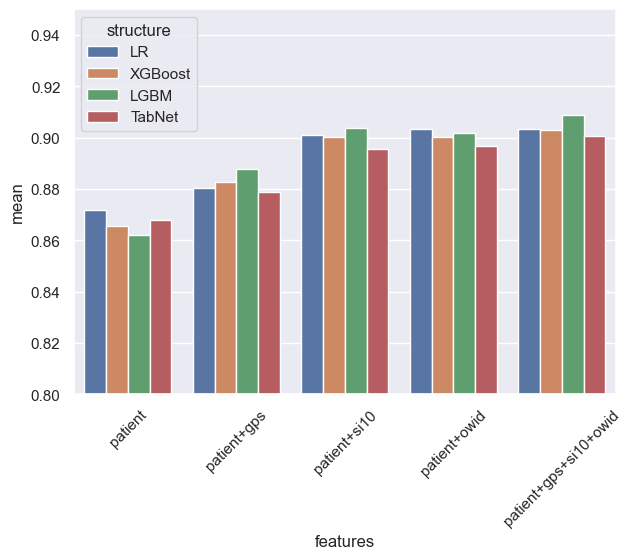

In [33]:
import seaborn as sns
sns.set_theme(style="darkgrid")

target_features = scall_features
sorterIndex = dict(zip(target_features, range(len(target_features))))

# Generate a rank column that will be used to sort
df_plot = df_scall[df_scall['features'].isin(target_features)]
df_plot['feature_index'] = df_plot['features'].map(sorterIndex)
df_plot = df_plot.sort_values('feature_index')
                   
# Create the bar plot.
plt.figure(figsize=(7,5))
sns.barplot(x="features", y="mean", hue="structure", data=df_plot)
plt.ylim(0.8, .95)
plt.xticks(rotation=45)

# Show the plot.
plt.show()